In [131]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import regex as re
from scipy.stats import f_oneway
from statsmodels.stats.multicomp import pairwise_tukeyhsd

In [50]:
# read files for table customers_by_store
directory = 'advanced_data_v2/customers_by_store_v2'
files = [f for f in os.listdir(directory)]
customers_by_store_df = pd.DataFrame()

for file in files:
    df = pd.read_csv(os.path.join(directory, file))
    customers_by_store_df = pd.concat([customers_by_store_df, df], ignore_index=True)

# read files for table monthly_transactions
directory2 = 'advanced_data_v2/monthly_transactions_v2'
files = [f for f in os.listdir(directory2)]
monthly_transactions_df = pd.DataFrame()

for file in files:
    df2 = pd.read_csv(os.path.join(directory2, file))
    monthly_transactions_df = pd.concat([monthly_transactions_df, df2], ignore_index=True)


# read files for table stores_by_city
directory3 = 'advanced_data_v2/stores_by_city_v2'
files = [f for f in os.listdir(directory3)]
stores_by_city_df = pd.DataFrame()

for file in files:
    df3 = pd.read_csv(os.path.join(directory3, file))
    stores_by_city_df = pd.concat([stores_by_city_df, df3], ignore_index=True)



### monthly_transactions_df cleaning

In [51]:
monthly_transactions_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   TxnID          10000 non-null  int64 
 1   custID         10000 non-null  int64 
 2   STORE_id       10000 non-null  int64 
 3   TxnDate        10000 non-null  object
 4   Amount         9928 non-null   object
 5   PaymentMethod  8329 non-null   object
dtypes: int64(3), object(3)
memory usage: 468.9+ KB


In [52]:
monthly_transactions_df.isnull().sum()

TxnID               0
custID              0
STORE_id            0
TxnDate             0
Amount             72
PaymentMethod    1671
dtype: int64

In [53]:
monthly_transactions_df.head()

,TxnID,custID,STORE_id,TxnDate,Amount,PaymentMethod
0,2100,1072,25,2024-10-26,330.64,Mobile
1,3347,1078,22,2024-10-15,245.78,Credit Card
2,4647,1064,29,2024-10-19,$111.82,NaN
3,5565,1072,27,2024-10-03,151.9,CC
4,7812,1079,23,2024-10-31,47.54,Unknown


In [54]:
monthly_transactions_df.columns = monthly_transactions_df.columns.str.strip()


def clean_payment(val):
    patterns = [
    (re.compile(r'mobile'), 'mobile'),
    (re.compile(r'(credit|card|cc)'), 'credit_card'),
    (re.compile(r'cash'), 'cash'),
    (re.compile(r'unknown'), np.nan)
    ]
    if pd.isna(val):
        return np.nan
    val = val.lower().strip()
    for pattern, label in patterns:
        if pattern.search(val):
            return label
    return 'other'  # default if nothing matches

monthly_transactions_df['PaymentMethod'] = monthly_transactions_df['PaymentMethod'].apply(clean_payment)

monthly_transactions_df['TxnDate'] = pd.to_datetime(monthly_transactions_df['TxnDate'], format='mixed')

monthly_transactions_df['Amount'] = pd.to_numeric(
                                                    monthly_transactions_df['Amount']
                                                    .astype(str)
                                                    .str.replace(r'[^0-9.\-]', '', regex=True)
                                                )
monthly_transactions_df['TxnID'] = pd.to_numeric(
                                                    monthly_transactions_df['TxnID']
                                                    .astype(str)
                                                    .str.replace(r'[^0-9.\-]', '', regex=True)).astype('Int64')

monthly_transactions_df['custID'] = pd.to_numeric(
                                                    monthly_transactions_df['custID']
                                                    .astype(str)
                                                    .str.replace(r'[^0-9.\-]', '', regex=True)).astype('Int64')

monthly_transactions_df['STORE_id'] = pd.to_numeric(
                                                    monthly_transactions_df['STORE_id']
                                                    .astype(str)
                                                    .str.replace(r'[^0-9.\-]', '', regex=True)).astype('Int64')

monthly_transactions_df.drop_duplicates()
monthly_transactions_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   TxnID          10000 non-null  Int64         
 1   custID         10000 non-null  Int64         
 2   STORE_id       10000 non-null  Int64         
 3   TxnDate        10000 non-null  datetime64[ns]
 4   Amount         9787 non-null   float64       
 5   PaymentMethod  7165 non-null   object        
dtypes: Int64(3), datetime64[ns](1), float64(1), object(1)
memory usage: 498.2+ KB


In [55]:
monthly_transactions_df.head()

,TxnID,custID,STORE_id,TxnDate,Amount,PaymentMethod
0,2100,1072,25,2024-10-26,330.64,mobile
1,3347,1078,22,2024-10-15,245.78,credit_card
2,4647,1064,29,2024-10-19,111.82,NaN
3,5565,1072,27,2024-10-03,151.90,credit_card
4,7812,1079,23,2024-10-31,47.54,NaN


### cleaning customers_by_store

In [56]:
customers_by_store_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1030 entries, 0 to 1029
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   custID          1030 non-null   int64 
 1   Customer Name   980 non-null    object
 2   PreferredStore  1030 non-null   int64 
 3   join_date       1030 non-null   object
 4   Phone #         927 non-null    object
dtypes: int64(2), object(3)
memory usage: 40.4+ KB


In [57]:
customers_by_store_df.isnull().sum()

custID              0
Customer Name      50
PreferredStore      0
join_date           0
Phone #           103
dtype: int64

In [58]:
customers_by_store_df.head()

,custID,Customer Name,PreferredStore,join_date,Phone #
0,17,Charlie,1,2025-09-03,SHORT
1,76,Dana,1,2025-02-26,555.1234
2,79,Bob 😊,1,2025-03-13,999-ERROR
3,88,Frank ®,1,2025-01-25,5551234
4,98,Frank ö,1,2025-05-28,555.1234


In [59]:
customers_by_store_df['Phone #'].unique()

array(['SHORT', '555.1234', '999-ERROR', '5551234', '(555) 123-4567',
       '+1 555 987 6543', nan, '555-1234', 'LONG-NUMBER-TOO-LONG',
       '010-12345678', '999ERROR', '+1.555.987.6543', 'LONGNUMBERTOOLONG',
       '01012345678', '(555) 1234567'], dtype=object)

In [60]:
# Step 1: Standardize to string and convert any existing NaNs to a placeholder string
#         for consistent regex application. We'll convert back to NaN later.
#         Using fillna('') ensures the string methods work without errors on np.nan
customers_by_store_df['Phone #'] = customers_by_store_df['Phone #'].fillna('').astype(str)

# Step 2: Aggressively extract only digits
#         This is the core for converting all inputs to their numeric components.
customers_by_store_df['Phone #'] = customers_by_store_df['Phone #'].str.replace(r'[^0-9]', '', regex=True)

# Step 3: Filter based on length and content
#         This is where we identify non-phone-number strings *after* digit extraction.
#         Any string that, after digit extraction, is either:
#         - Too short or too long to be a phone number (e.g., < 7 or > 15 digits)
#         - Becomes an empty string (e.g., 'SHORT', 'N/A', 'NO PHONE' all become '')
#         - Is still pd.NA (from original NaN that wasn't touched by .fillna('') if applicable)
#         should be marked as NaN.

# Define acceptable length range for phone numbers
MIN_DIGITS = 7
MAX_DIGITS = 15

# Use a custom function for more flexible validation
def validate_and_finalize_phone_number(cleaned_digits):
    if pd.isna(cleaned_digits) or not isinstance(cleaned_digits, str):
        return np.nan # Catches original NaNs or non-string types

    # If it's an empty string after digit extraction (meaning it was purely text)
    if cleaned_digits == '':
        return np.nan

    # Check length validity
    if not (MIN_DIGITS <= len(cleaned_digits) <= MAX_DIGITS):
        return np.nan # Not a valid length

    # If it passes checks, return the cleaned number
    return cleaned_digits

customers_by_store_df['Phone #'] = customers_by_store_df['Phone #'].apply(validate_and_finalize_phone_number)

# Optional: Format to a specific display style (e.g., (XXX) XXX-XXXX for 10-digit US numbers)
def format_phone_number(phone_num):
    if pd.isna(phone_num):
        return np.nan
    phone_num_str = str(phone_num)
    if len(phone_num_str) == 10: # US style
        return f"({phone_num_str[0:3]}) {phone_num_str[3:6]}-{phone_num_str[6:]}"
    elif len(phone_num_str) == 11 and phone_num_str.startswith('01'): # Egyptian mobile style
        return f"{phone_num_str[0:3]}-{phone_num_str[3:7]}-{phone_num_str[7:]}"
    return phone_num_str # Return as is if no specific format matches

customers_by_store_df['Phone #'] = customers_by_store_df['Phone #'].apply(format_phone_number)



In [61]:
customers_by_store_df.drop_duplicates()

customers_by_store_df.columns = customers_by_store_df.columns.str.strip()


customers_by_store_df['Customer Name'] = customers_by_store_df['Customer Name'].apply(
	lambda x: re.sub(r"[^A-Za-z\s]", '', x) if isinstance(x, str) else x
).str.strip()
customers_by_store_df['Customer Name'] = customers_by_store_df['Customer Name'].str.title()

customers_by_store_df['join_date'] = pd.to_datetime(customers_by_store_df['join_date'], format='%Y-%m-%d')

customers_by_store_df.drop_duplicates()

customers_by_store_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1030 entries, 0 to 1029
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   custID          1030 non-null   int64         
 1   Customer Name   980 non-null    object        
 2   PreferredStore  1030 non-null   int64         
 3   join_date       1030 non-null   datetime64[ns]
 4   Phone #         604 non-null    object        
dtypes: datetime64[ns](1), int64(2), object(2)
memory usage: 40.4+ KB


In [62]:
print(customers_by_store_df['Customer Name'].unique())

['Charlie' 'Dana' 'Bob' 'Frank' 'Heidi' 'Grace' 'Alice' 'Eve' nan
 'Jane Doe' 'Charlia' 'Eva' 'Graca' 'Alica']


In [63]:
customers_by_store_df.head()

,custID,Customer Name,PreferredStore,join_date,Phone #
0,17,Charlie,1,2025-09-03,NaN
1,76,Dana,1,2025-02-26,5551234
2,79,Bob,1,2025-03-13,NaN
3,88,Frank,1,2025-01-25,5551234
4,98,Frank,1,2025-05-28,5551234


#### cleaning stores_by_city

In [64]:
stores_by_city_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20 entries, 0 to 19
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   STORE_id   20 non-null     int64 
 1   StoreName  20 non-null     object
 2   Size       20 non-null     object
 3   City       20 non-null     object
 4   Opening    20 non-null     object
dtypes: int64(1), object(4)
memory usage: 932.0+ bytes


In [65]:
stores_by_city_df.isnull().sum()

STORE_id     0
StoreName    0
Size         0
City         0
Opening      0
dtype: int64

In [66]:
stores_by_city_df['Size'].unique()

array(['Large', 'Small', 'Medium', 'large', 'MEDIUM'], dtype=object)

In [67]:
stores_by_city_df.head()

,STORE_id,StoreName,Size,City,Opening
0,1,Store_1 Corp.,Large,Alex.,2025-02-25
1,2,Store_2 Limited,Large,Alex.,2025-07-05
2,3,Store_3 Corp.,Small,Alexandria,2025-06-04
3,8,Store_8™,Large,Alexandira,2025-01-14
4,10,Store_10§,Small,Alexandria,2025-04-27


In [68]:
stores_by_city_df.drop_duplicates()

# Strip whitespace from all column names to avoid KeyError
stores_by_city_df.columns = stores_by_city_df.columns.str.strip()

stores_by_city_df['Size'] = stores_by_city_df['Size'].str.title()


city_mapping_title = {
    'Alex.': 'Alexandria',
    'Alexandira': 'Alexandria',
    'Al-Iskandariyah': 'Alexandria',
    'Cai': 'Cairo',
    'Al-Qahira': 'Cairo',
    'Cario': 'Cairo',
    'Gizeh': 'Giza',
    'Gizah': 'Giza',
    'Jizah': 'Giza',
}
stores_by_city_df['City'] = stores_by_city_df['City'].str.strip()
stores_by_city_df['City'] = stores_by_city_df['City'].str.title()
stores_by_city_df['City'] = stores_by_city_df['City'].replace(city_mapping_title)

stores_by_city_df['Opening'] = pd.to_datetime(stores_by_city_df['Opening'], format='%Y-%m-%d')
try:
    stores_by_city_df.drop(columns='StoreName' , inplace=True)
except:
    pass

stores_by_city_df.drop_duplicates()

stores_by_city_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20 entries, 0 to 19
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   STORE_id  20 non-null     int64         
 1   Size      20 non-null     object        
 2   City      20 non-null     object        
 3   Opening   20 non-null     datetime64[ns]
dtypes: datetime64[ns](1), int64(1), object(2)
memory usage: 772.0+ bytes


In [69]:
stores_by_city_df.head()

,STORE_id,Size,City,Opening
0,1,Large,Alexandria,2025-02-25
1,2,Large,Alexandria,2025-07-05
2,3,Small,Alexandria,2025-06-04
3,8,Large,Alexandria,2025-01-14
4,10,Small,Alexandria,2025-04-27


# 1. Merge The DataFrames

First, we want to combine the data into a single, comprehensive DataFrame. This will allow us to analyze relationships between customers, their transactions, and the stores they shop at, but before that we will, But before that, we will identify any orphan records which is that there are any records in the transaction table but have no connection or relation to the other two tables.

we'll need to perform two merges:

- Merge `monthly_transactions_df` with `customers_by_store_df` on the `custID` column.
- Merge the result with `stores_df` on the `STORE_id` column.

This will give us a "master" DataFrame that links each transaction to detailed customer and store information.


In [70]:
# orphan records in the customers table (transactions with no matching customer)
orphan_r_cutomer_df = pd.merge(monthly_transactions_df, customers_by_store_df, how='left')
orphan_r_store_df = pd.merge(monthly_transactions_df, stores_by_city_df, how='left')
cust_orphan = orphan_r_cutomer_df[orphan_r_cutomer_df['join_date'].isna()]['custID'].values
store_orphan = orphan_r_store_df[orphan_r_store_df['Size'].isna()]['custID'].values
print(f'the len of store orphan rows = {len(store_orphan)} \nthe len of customer orphan rows = {len(cust_orphan)}')

#Checking if the same records are the same in both customer and store tables if the sum is = 200 then its the same
print(f'the sum of bool valus = {sum(store_orphan == cust_orphan)}')

#look like they are the same so in the analysis part we are gone ignore them

the len of store orphan rows = 200 
the len of customer orphan rows = 200
the sum of bool valus = 200


In [71]:
# we will go with right join because customers can have no trasactions that will help us
# find inactive customers

master_df = pd.merge(
    monthly_transactions_df,
    customers_by_store_df,
    on='custID',
    how='inner'
)

master_df = pd.merge(
    master_df,
    stores_by_city_df,
    on='STORE_id',
    how='inner'
)

master_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9800 entries, 0 to 9799
Data columns (total 13 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   TxnID           9800 non-null   Int64         
 1   custID          9800 non-null   Int64         
 2   STORE_id        9800 non-null   Int64         
 3   TxnDate         9800 non-null   datetime64[ns]
 4   Amount          9593 non-null   float64       
 5   PaymentMethod   7017 non-null   object        
 6   Customer Name   9346 non-null   object        
 7   PreferredStore  9800 non-null   int64         
 8   join_date       9800 non-null   datetime64[ns]
 9   Phone #         5728 non-null   object        
 10  Size            9800 non-null   object        
 11  City            9800 non-null   object        
 12  Opening         9800 non-null   datetime64[ns]
dtypes: Int64(3), datetime64[ns](3), float64(1), int64(1), object(5)
memory usage: 1.0+ MB


In [72]:
# check if there are mulitble join date
count_join_date = master_df.groupby('custID').agg(
    count_join_date = ('join_date' , 'nunique')
    )

count_join_date[count_join_date['count_join_date'] > 1]

,count_join_date
custID,


In [73]:
# check how long customer take to make its first transaction
fist_trans = master_df.groupby('custID').agg(
    first_txn = ('TxnDate' , 'min'),
    join_date = ('join_date' , 'min')
)

fist_trans['diff'] = fist_trans['first_txn'] - fist_trans['join_date']
fist_trans

,first_txn,join_date,diff
custID,,,
1,2025-01-21,2025-03-06,-44 days
2,2025-09-10,2025-09-19,-9 days
3,2025-01-09,2025-05-18,-129 days
4,2025-07-02,2025-11-05,-126 days
5,2025-04-01,2025-03-07,25 days
...,...,...,...
1026,2025-04-16,2025-09-03,-140 days
1027,2025-01-09,2025-11-05,-300 days
1028,2025-02-26,2025-01-16,41 days


In [74]:
master_df.head()

,TxnID,custID,STORE_id,TxnDate,Amount,PaymentMethod,Customer Name,PreferredStore,join_date,Phone #,Size,City,Opening
0,1367,505,12,2024-11-29,55.62,credit_card,Dana,12,2025-01-24,NaN,Medium,Alexandria,2025-11-03
1,9221,592,18,2024-11-28,40.11,credit_card,Dana,13,2025-01-04,NaN,Medium,Alexandria,2025-12-16
2,609,645,8,2024-12-22,185.19,NaN,Charlie,2,2025-07-12,010-1234-5678,Large,Alexandria,2025-01-14
3,808,420,10,2024-12-12,142.60,cash,Eve,5,2025-01-28,NaN,Small,Alexandria,2025-04-27
4,887,369,1,2024-12-21,420.94,credit_card,Frank,15,2025-02-19,NaN,Large,Alexandria,2025-02-25


# 2. Exploratory Data Analysis (EDA)
## Customer Analysis

- Who are our top customers? Identify customers with the highest transaction amounts or frequency.


In [75]:
master_df.head()

,TxnID,custID,STORE_id,TxnDate,Amount,PaymentMethod,Customer Name,PreferredStore,join_date,Phone #,Size,City,Opening
0,1367,505,12,2024-11-29,55.62,credit_card,Dana,12,2025-01-24,NaN,Medium,Alexandria,2025-11-03
1,9221,592,18,2024-11-28,40.11,credit_card,Dana,13,2025-01-04,NaN,Medium,Alexandria,2025-12-16
2,609,645,8,2024-12-22,185.19,NaN,Charlie,2,2025-07-12,010-1234-5678,Large,Alexandria,2025-01-14
3,808,420,10,2024-12-12,142.60,cash,Eve,5,2025-01-28,NaN,Small,Alexandria,2025-04-27
4,887,369,1,2024-12-21,420.94,credit_card,Frank,15,2025-02-19,NaN,Large,Alexandria,2025-02-25


In [76]:
# top customers
master_df.groupby('custID').agg(
    total_Amount = ('Amount','sum'),
    join_date = ('join_date','min'),
    PreferredStore = ('PreferredStore','first'),
    frequency = ('TxnID' , 'count')
).sort_values('total_Amount' , ascending= False).head(10)

,total_Amount,join_date,PreferredStore,frequency
custID,,,,
149,5749.85,2025-11-13,7,19
999,5522.60,2025-03-02,6,17
559,5516.45,2025-03-19,4,16
387,5351.01,2025-01-16,14,21
307,5263.18,2025-06-21,2,20
986,5199.65,2025-06-09,1,15
849,5102.64,2025-10-27,9,18
988,5008.95,2025-02-09,8,16
762,4909.64,2025-12-04,4,18


- When do customers join?

C:\Users\zzppo\AppData\Local\Temp\ipykernel_7408\1018401299.py:42: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\zzppo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


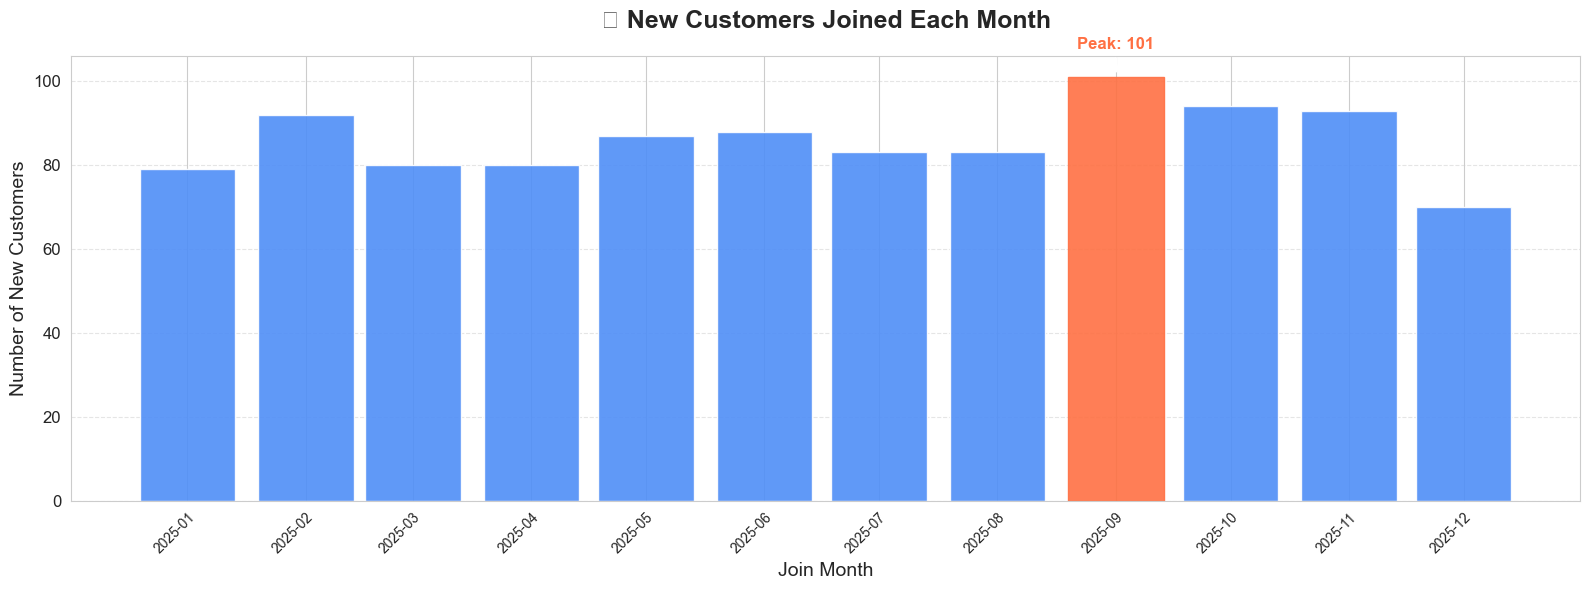

In [77]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Group by month and count new customers
join_counts = customers_by_store_df['join_date'].dropna().dt.to_period('M').value_counts().sort_index()
join_counts.index = join_counts.index.to_timestamp()

# Create figure with larger width to accommodate all labels
plt.figure(figsize=(16, 6))
bars = plt.bar(join_counts.index, join_counts.values, width=25, color='#4F8EF7', edgecolor='white', alpha=0.9)

# Highlight the month with most joins
max_idx = join_counts.values.argmax()
bars[max_idx].set_color('#FF7043')

# Improved x-axis formatting
ax = plt.gca()
ax.xaxis.set_major_locator(mdates.MonthLocator())  # Show every month
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))  # Format as YYYY-MM
plt.setp(ax.get_xticklabels(), rotation=45, ha='right', rotation_mode='anchor')  # Better label alignment

plt.title('📈 New Customers Joined Each Month', fontsize=18, weight='bold', pad=20)
plt.xlabel('Join Month', fontsize=14)
plt.ylabel('Number of New Customers', fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.yticks(fontsize=12)

# Annotate the highest bar
plt.annotate(
    f"Peak: {join_counts.values[max_idx]}",
    xy=(join_counts.index[max_idx], join_counts.values[max_idx]),
    xytext=(0, 20),
    textcoords='offset points',
    ha='center',
    fontsize=12,
    color='#FF7043',
    weight='bold',
    arrowprops=dict(facecolor='#FF7043', arrowstyle='->', lw=2)
)

# Adjust layout to prevent label cutoff
plt.tight_layout()
plt.show()

- What is the customer distribution per store? Analyze how many customers are associated with each `PreferredStore`.

C:\Users\zzppo\AppData\Local\Temp\ipykernel_7408\2492212066.py:36: UserWarning: Glyph 127980 (\N{DEPARTMENT STORE}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\zzppo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 127980 (\N{DEPARTMENT STORE}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


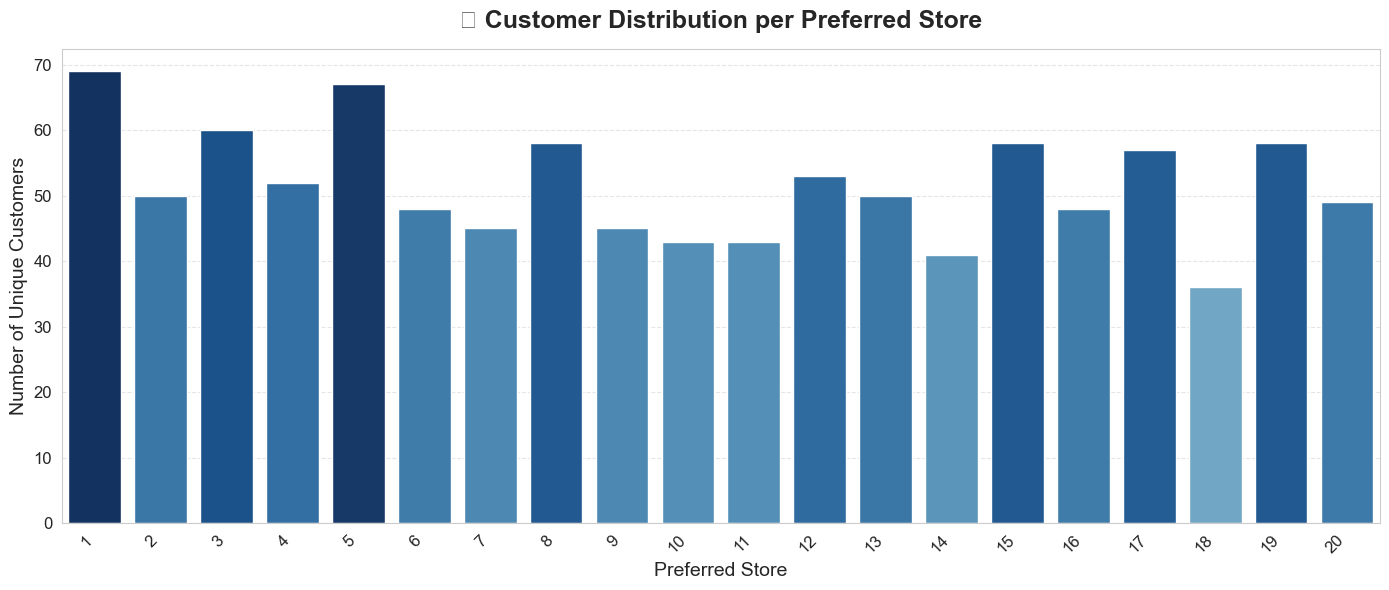

In [78]:
# Count unique customers per PreferredStore and sort by value
store_customer_counts = customers_by_store_df.groupby('PreferredStore')['custID'].nunique()

# Get values and indices in sorted order
sorted_values = store_customer_counts.sort_values()
sorted_indices = sorted_values.index

# Calculate color intensity based on sorted values
color_intensities = sorted_values / sorted_values.max()
colors = [plt.cm.Blues(intensity) for intensity in color_intensities]

# Create color mapping dictionary
color_dict = dict(zip(sorted_indices, colors))

# Map original indices to colors
final_colors = [color_dict[idx] for idx in store_customer_counts.index]

plt.figure(figsize=(14, 6))
ax = sns.barplot(
    x=store_customer_counts.index,
    y=store_customer_counts.values,
    palette=final_colors,
    errorbar='sd',
    hue=store_customer_counts.index,
    legend=False
)

plt.title('🏬 Customer Distribution per Preferred Store', fontsize=18, weight='bold', pad=15)
plt.xlabel('Preferred Store', fontsize=14)
plt.ylabel('Number of Unique Customers', fontsize=14)
plt.xticks(rotation=45, ha='right', fontsize=12)
plt.yticks(fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.5)

plt.rcParams['font.family'] = 'Segoe UI Emoji'
plt.tight_layout()
plt.show()

## Transaction Analysis

- What is the distribution of transaction amounts? A histogram of the `Amount` column can reveal if you have many small transactions or a few large ones.
- What are the most common payment methods? A bar chart of `PaymentMethod` will show you how people prefer to pay.
- Are there transaction trends over time? Plot the total transaction `Amount` against `TxnDate` to spot seasonal patterns or growth.



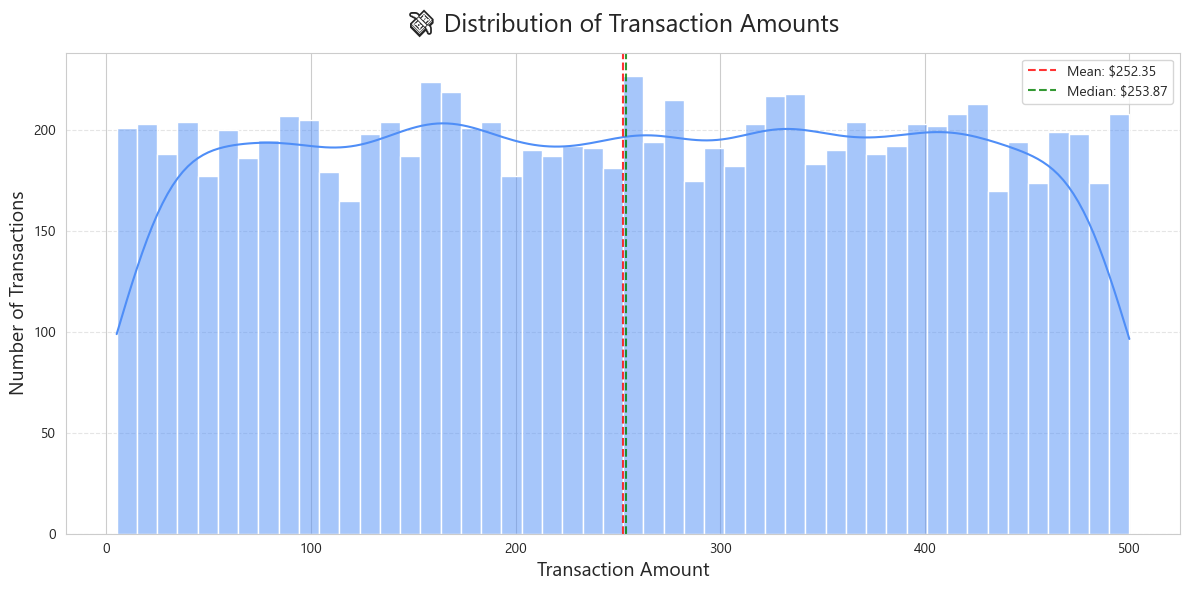

In [79]:
# Calculate statistics
amount_stats = monthly_transactions_df['Amount'].describe()
median_amount = amount_stats['50%']
mean_amount = amount_stats['mean']

plt.figure(figsize=(12, 6))

# Create main distribution plot
sns.histplot(
    monthly_transactions_df['Amount'].dropna(),
    bins=50,
    kde=True,
    color='#4F8EF7',
    edgecolor='white'
)

# Add vertical lines for mean and median
plt.axvline(mean_amount, color='red', linestyle='--', alpha=0.8, label=f'Mean: ${mean_amount:.2f}')
plt.axvline(median_amount, color='green', linestyle='--', alpha=0.8, label=f'Median: ${median_amount:.2f}')

plt.title('💸 Distribution of Transaction Amounts', fontsize=18, weight='bold', pad=15)
plt.xlabel('Transaction Amount', fontsize=14)
plt.ylabel('Number of Transactions', fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.legend(fontsize=10)

# Set font for emoji support
plt.rcParams['font.family'] = 'Segoe UI Emoji'
plt.tight_layout()
plt.show()

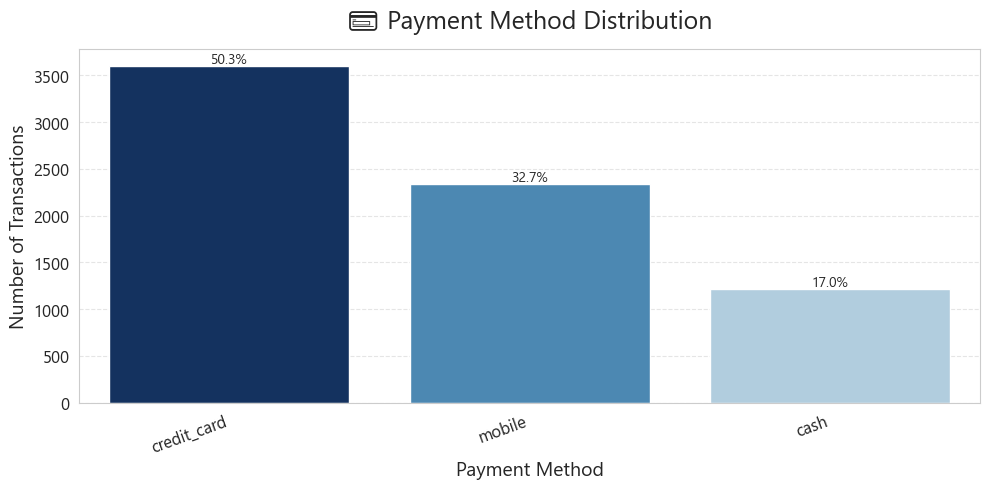

In [80]:
# Count transactions per PaymentMethod
payment_counts = monthly_transactions_df['PaymentMethod'].value_counts()

# Calculate percentages for annotations
percentages = (payment_counts / payment_counts.sum() * 100).round(1)

# Create color gradient based on values
sorted_values = payment_counts.sort_values()
color_intensities = sorted_values / sorted_values.max()
colors = [plt.cm.Blues(intensity) for intensity in color_intensities]
color_dict = dict(zip(sorted_values.index, colors))
final_colors = [color_dict[idx] for idx in payment_counts.index]

plt.figure(figsize=(10, 5))
bars = sns.barplot(
    x=payment_counts.index,
    y=payment_counts.values,
    palette=final_colors,
    hue=payment_counts.index,
    legend=False
)

# Add percentage labels on top of bars
for i, (count, percentage) in enumerate(zip(payment_counts, percentages)):
    plt.text(i, count, f'{percentage}%', 
             ha='center', va='bottom', fontsize=10)

plt.rcParams['font.family'] = 'Segoe UI Emoji'
plt.title('💳 Payment Method Distribution', fontsize=18, weight='bold', pad=15)
plt.xlabel('Payment Method', fontsize=14)
plt.ylabel('Number of Transactions', fontsize=14)
plt.xticks(rotation=20, ha='right', fontsize=12)
plt.yticks(fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


## Store Analysis

- Which stores perform the best? Group by `StoreName` and sum the transaction `Amount` to find your top-performing stores.

C:\Users\zzppo\AppData\Local\Temp\ipykernel_7408\749441405.py:45: UserWarning: Glyph 127980 (\N{DEPARTMENT STORE}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\zzppo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 127980 (\N{DEPARTMENT STORE}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


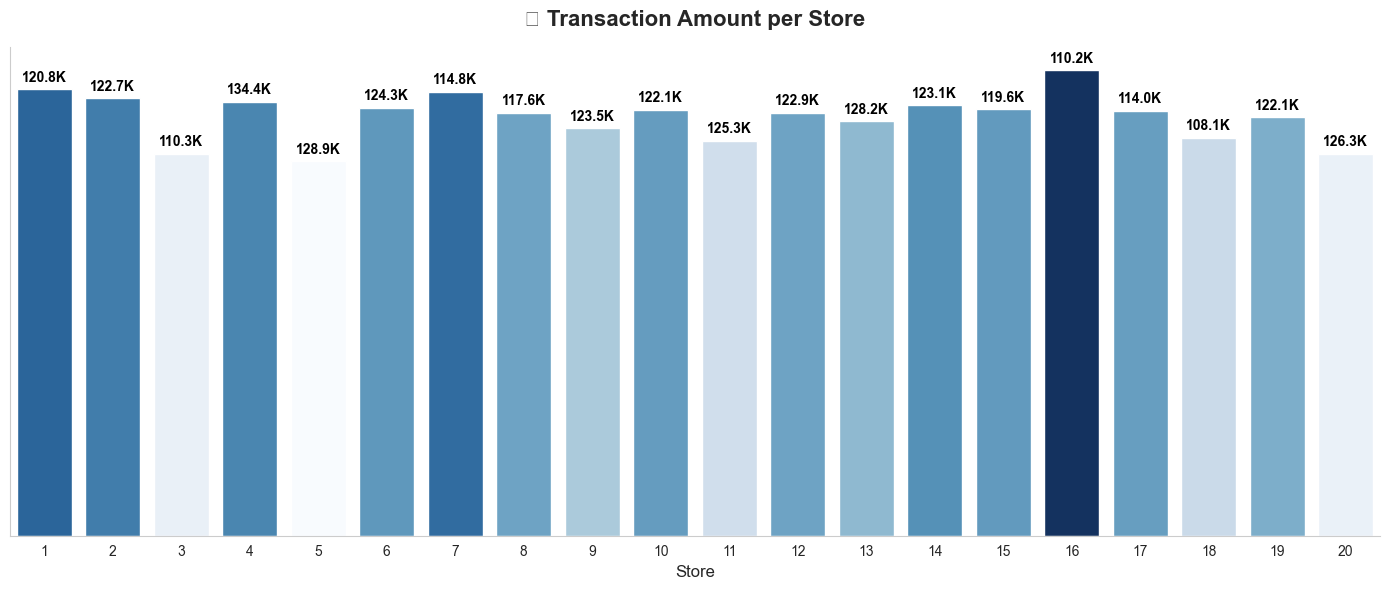

In [135]:
# Prepare the data (no sorting needed here)
store_tra_amount = master_df.groupby('STORE_id')['Amount'].sum()
store_df = store_tra_amount.reset_index()
store_df.columns = ['STORE_id', 'Amount']
store_df['Amount_K'] = (store_df['Amount'] / 1000).round(1)

# Plot
plt.figure(figsize=(14, 6))
sns.set_style("whitegrid")

# --- Let seaborn handle the color mapping ---
ax = sns.barplot(
    data=store_df,
    x='STORE_id',
    y='Amount',
    hue='Amount',        # Use 'Amount' to determine the color
    palette='Blues',     # Specify the colormap
    dodge=False,         # Prevent bars from shifting
    legend=False         # Hide the color bar legend
)

# Add aligned text labels
# We need to sort the dataframe here to ensure labels match the plot order
store_df = store_df.sort_values('STORE_id')
for patch, label in zip(ax.patches, store_df['Amount_K']):
    x = patch.get_x() + patch.get_width() / 2
    y = patch.get_height()
    ax.text(
        x,
        y + store_df['Amount'].max() * 0.01,
        f'{label}K',
        ha='center',
        va='bottom',
        fontsize=10,
        fontweight='bold',
        color='black'
    )

# Final touchups
ax.set_ylabel('')
ax.set_xlabel('Store', fontsize=12)
ax.set_yticks([])
ax.set_title('🏬 Transaction Amount per Store', fontsize=16, fontweight='bold', pad=15)
sns.despine()
plt.tight_layout()
plt.show()

- Does store size matter?

In [136]:
size_analysis = master_df.groupby('Size').agg(
    Average_Amount=('Amount', 'mean'),
    Total_Amount=('Amount', 'sum'),
    Transaction_Count=('Amount', 'count'),
    Number_of_Stores=('STORE_id', 'nunique')
)
size_analysis['Per Store Total Sales'] = (size_analysis['Total_Amount'] /   size_analysis['Number_of_Stores']).round(2)
size_analysis

,Average_Amount,Total_Amount,Transaction_Count,Number_of_Stores,Per Store Total Sales
Size,,,,,
Large,256.454874,755516.06,2946,6,125919.34
Medium,251.517929,964319.74,3834,8,120539.97
Small,248.553402,699180.72,2813,6,116530.12


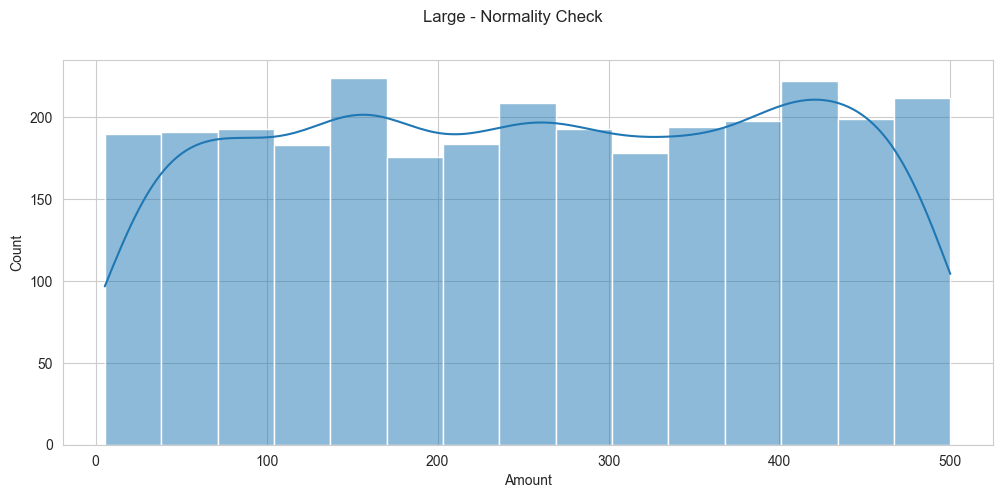

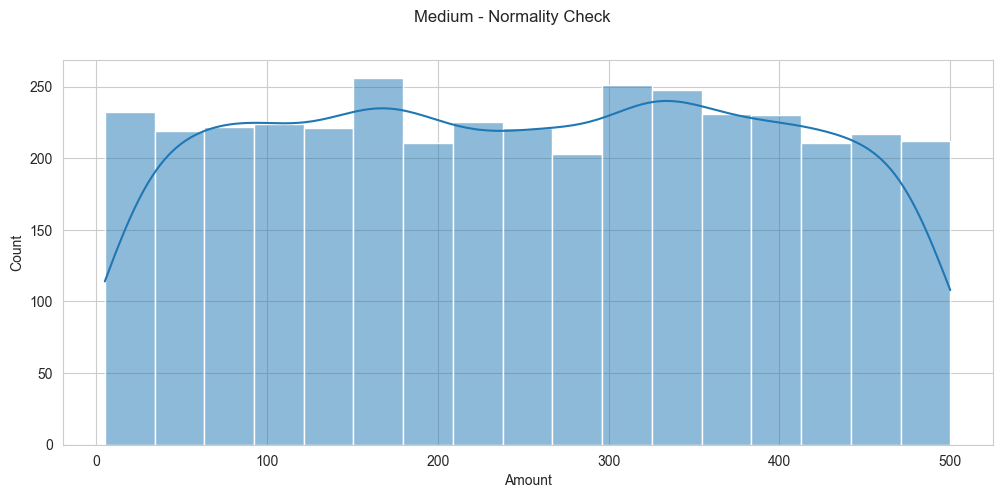

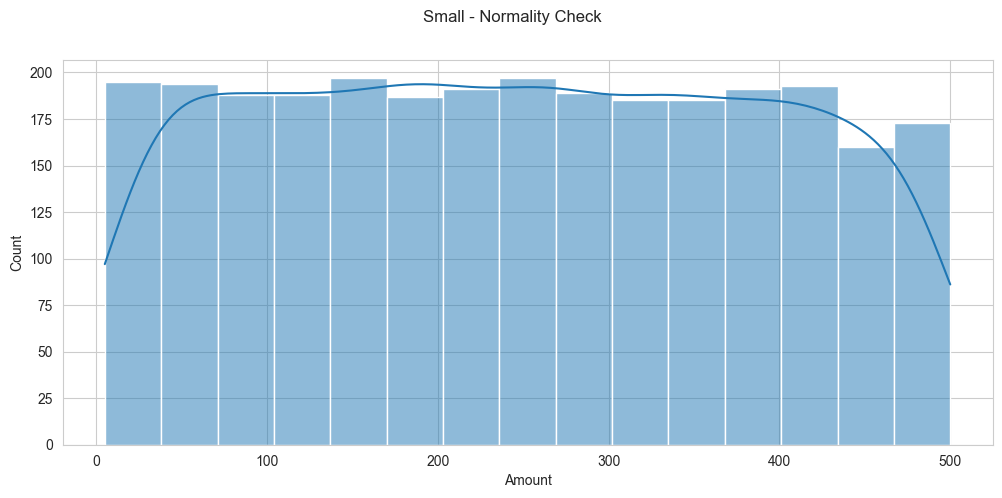

In [137]:
for size in size_analysis.index:
    values = master_df.loc[master_df['Size'] == size, 'Amount'].dropna()
    plt.figure(figsize=(12, 5))
    plt.suptitle(f"{size} - Normality Check")
    plt.subplot(1, 1, 1)
    sns.histplot(values, kde=True)


Sample_means mean for Large = 256.0859
Sample_means std for Large = 14.5037


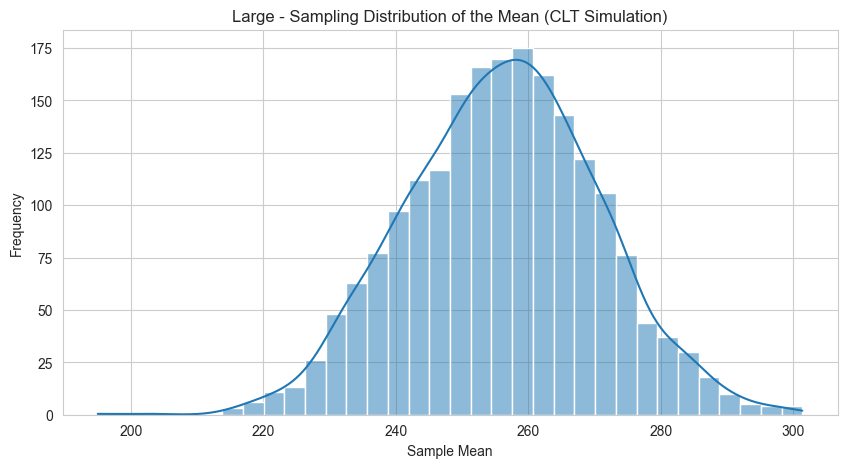

Sample_means mean for Medium = 251.4765
Sample_means std for Medium = 13.9192


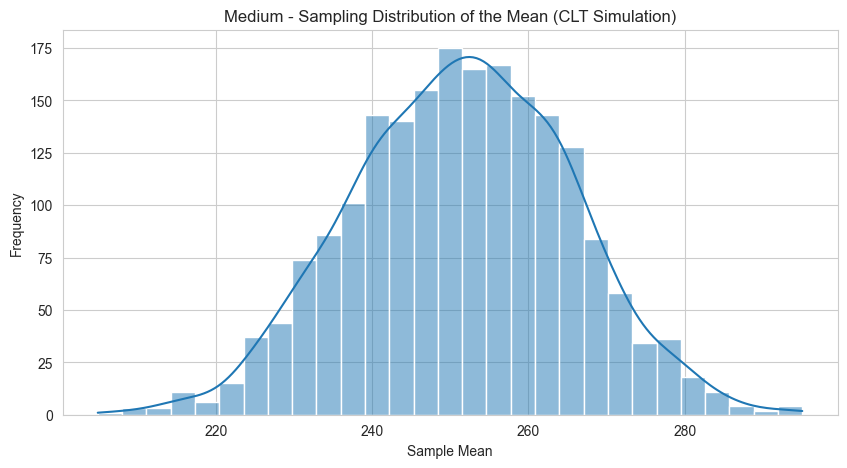

Sample_means mean for Small = 248.2178
Sample_means std for Small = 14.3972


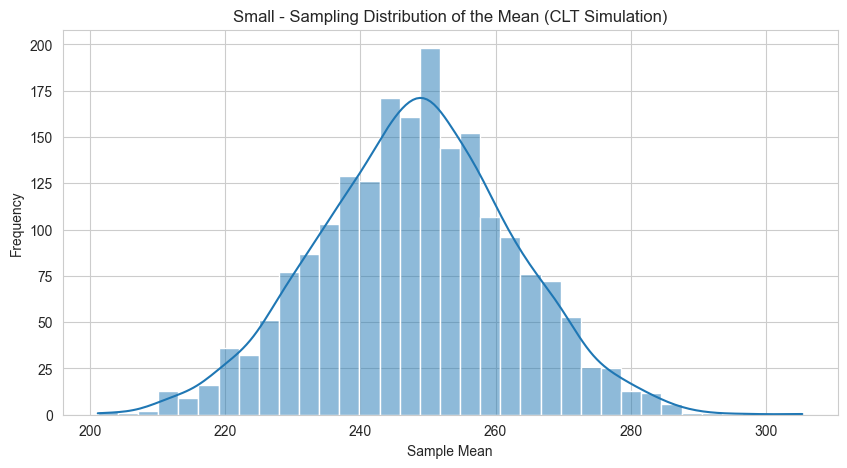

In [138]:
# Settings
sample_size = 100   # Can be 30, 50, 100... (CLT says large enough, often ≥ 30)
num_samples = 2000 # Number of samples to simulate


# Dictionary to store sample means for each city
size_sample_means = {}

# Generate sample means for each city
for size in size_analysis.index:
    values = master_df.loc[master_df['Size'] == size, 'Amount'].dropna().values

    sample_means = []
    for _ in range(num_samples):
        sample = np.random.choice(values, size=sample_size, replace=True)
        sample_means.append(np.mean(sample))

    # Store sample means for ANOVA
    size_sample_means[size] = sample_means
    
    print(f"Sample_means mean for {size} = {np.mean(sample_means):.4f}")
    print(f"Sample_means std for {size} = {np.std(sample_means):.4f}")
    
    # Plot sampling distribution of the sample mean
    plt.figure(figsize=(10, 5))
    sns.histplot(sample_means, kde=True)
    plt.title(f"{size} - Sampling Distribution of the Mean (CLT Simulation)")
    plt.xlabel("Sample Mean")
    plt.ylabel("Frequency")
    plt.show()


In [139]:
print("\n" + "="*50)
print("ANOVA ANALYSIS")
print("="*50)

# Prepare data for ANOVA
cities = list(size_sample_means.keys())
sample_means_data = list(size_sample_means.values())

# Perform one-way ANOVA
f_statistic, p_value = f_oneway(*sample_means_data)

print(f"\nANOVA Results:")
print(f"F-statistic: {f_statistic:.4f}")
print(f"p-value: {p_value:.6f}")

# Interpretation
alpha = 0.05
if p_value < alpha:
    print(f"\nResult: SIGNIFICANT (p < {alpha})")
    print("We reject the null hypothesis.")
    print("There IS a significant difference between city means.")
else:
    print(f"\nResult: NOT SIGNIFICANT (p >= {alpha})")
    print("We fail to reject the null hypothesis.")
    print("There is NO significant difference between city means.")



ANOVA ANALYSIS

ANOVA Results:
F-statistic: 153.3026
p-value: 0.000000

Result: SIGNIFICANT (p < 0.05)
We reject the null hypothesis.
There IS a significant difference between city means.


In [140]:
# Drop rows where Amount or City is missing
clean_df = master_df[['Amount', 'Size']].dropna()
tukey = pairwise_tukeyhsd(endog=clean_df['Amount'], groups=clean_df['Size'], alpha=0.05)
print(tukey)


Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj   lower   upper  reject
----------------------------------------------------
 Large Medium  -4.9369 0.3336 -13.1203 3.2464  False
 Large  Small  -7.9015 0.0892 -16.7065 0.9036  False
Medium  Small  -2.9645 0.6794 -11.2566 5.3275  False
----------------------------------------------------


- How does location impact sales? Analyze sales performance by `City`.

In [141]:
location_analysis = master_df.groupby('City').agg(
    Average_Amount=('Amount', 'mean'),
    Total_Amount=('Amount', 'sum'),
    Transaction_Count=('Amount', 'count'),
    Number_of_Stores=('STORE_id', 'nunique')
)

location_analysis['Per Store Total Sales'] = (location_analysis['Total_Amount'] /   location_analysis['Number_of_Stores']).round(2)
location_analysis

,Average_Amount,Total_Amount,Transaction_Count,Number_of_Stores,Per Store Total Sales
City,,,,,
Alexandria,249.659178,1191123.94,4771,10,119112.39
Cairo,255.185169,498631.82,1954,4,124657.96
Giza,254.275021,729260.76,2868,6,121543.46


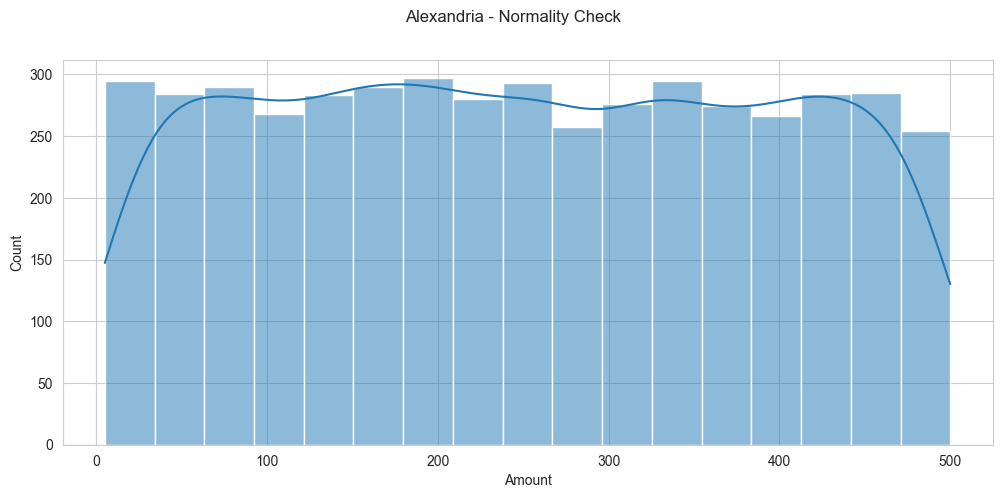

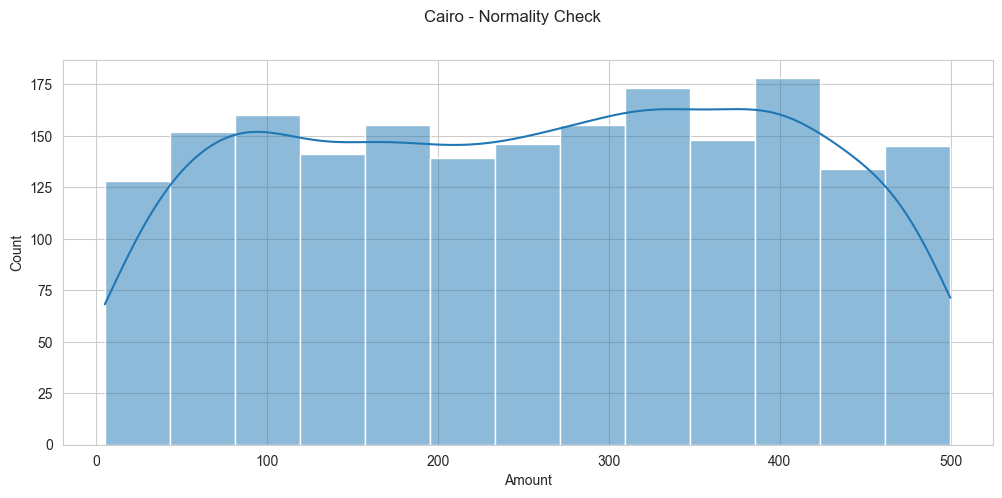

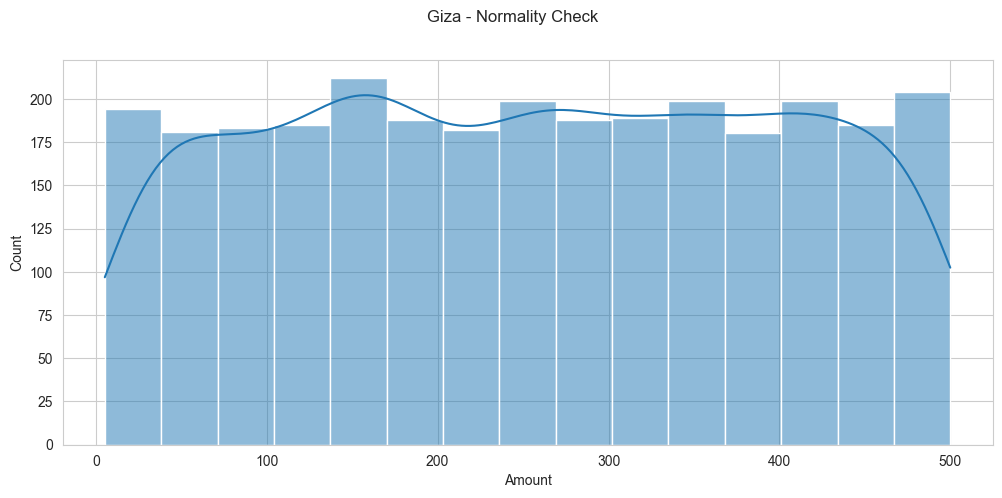

In [142]:
# Iterate over each city and plot the distribution of transaction amounts
for city in location_analysis.index:
    values = master_df.loc[master_df['City'] == city, 'Amount'].dropna()
    plt.figure(figsize=(12, 5))
    plt.suptitle(f"{city} - Normality Check")
    plt.subplot(1, 1, 1)
    sns.histplot(values, kde=True)


Sample_means mean for Alexandria = 249.4816
Sample_means std for Alexandria = 14.3771


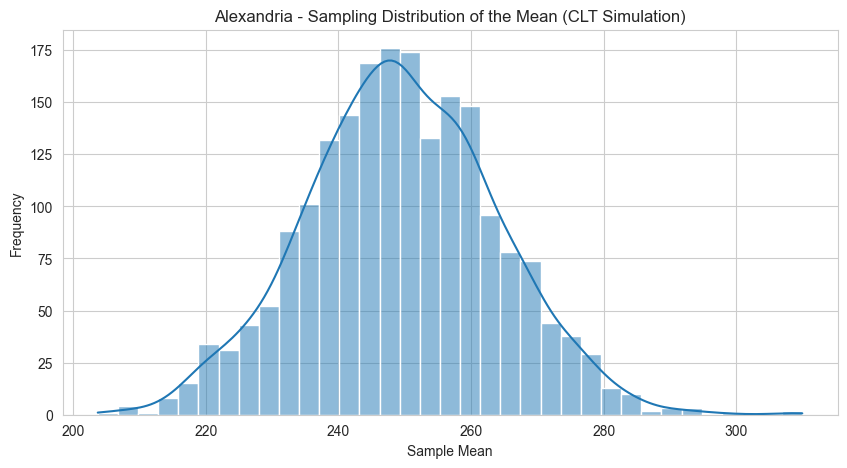

Sample_means mean for Cairo = 255.4274
Sample_means std for Cairo = 14.0986


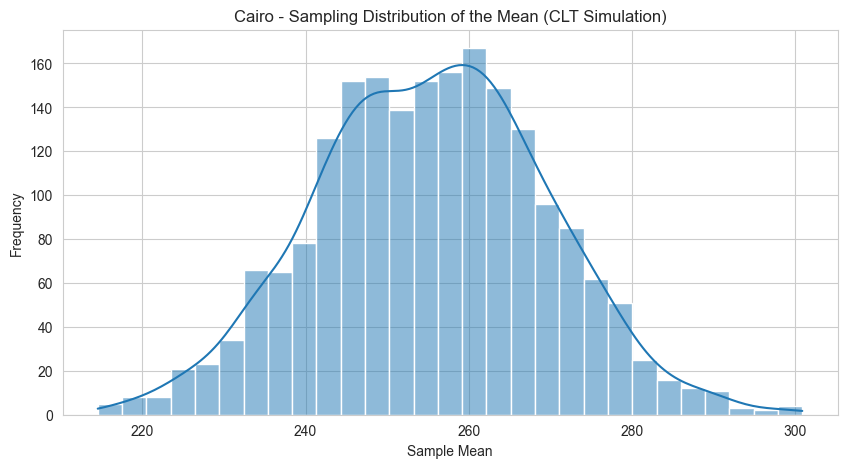

Sample_means mean for Giza = 254.3124
Sample_means std for Giza = 14.4136


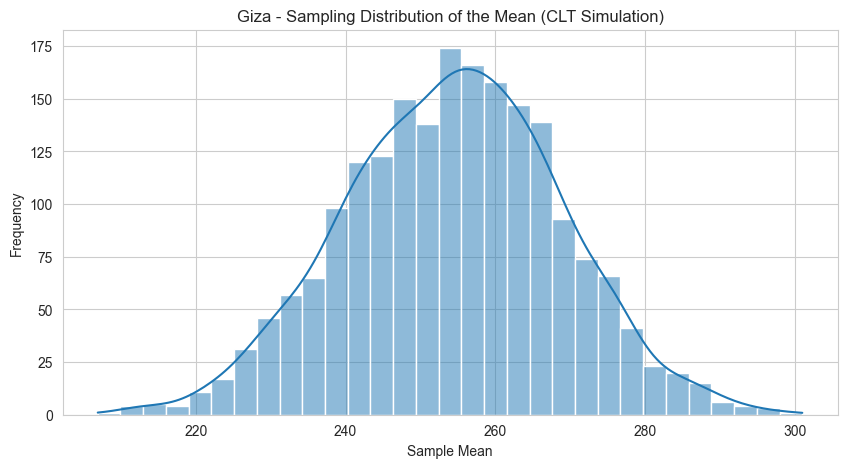

In [143]:
# Settings
sample_size = 100   # Can be 30, 50, 100... (CLT says large enough, often ≥ 30)
num_samples = 2000 # Number of samples to simulate

from scipy.stats import f_oneway

# Dictionary to store sample means for each city
city_sample_means = {}

# Generate sample means for each city
for city in location_analysis.index:
    values = master_df.loc[master_df['City'] == city, 'Amount'].dropna().values

    sample_means = []
    for _ in range(num_samples):
        sample = np.random.choice(values, size=sample_size, replace=True)
        sample_means.append(np.mean(sample))

    # Store sample means for ANOVA
    city_sample_means[city] = sample_means
    
    print(f"Sample_means mean for {city} = {np.mean(sample_means):.4f}")
    print(f"Sample_means std for {city} = {np.std(sample_means):.4f}")
    
    # Plot sampling distribution of the sample mean
    plt.figure(figsize=(10, 5))
    sns.histplot(sample_means, kde=True)
    plt.title(f"{city} - Sampling Distribution of the Mean (CLT Simulation)")
    plt.xlabel("Sample Mean")
    plt.ylabel("Frequency")
    plt.show()


In [144]:
print("\n" + "="*50)
print("ANOVA ANALYSIS")
print("="*50)

# Prepare data for ANOVA
cities = list(city_sample_means.keys())
sample_means_data = list(city_sample_means.values())

# Perform one-way ANOVA
f_statistic, p_value = f_oneway(*sample_means_data)

print(f"\nANOVA Results:")
print(f"F-statistic: {f_statistic:.4f}")
print(f"p-value: {p_value:.6f}")

# Interpretation
alpha = 0.05
if p_value < alpha:
    print(f"\nResult: SIGNIFICANT (p < {alpha})")
    print("We reject the null hypothesis.")
    print("There IS a significant difference between city means.")
else:
    print(f"\nResult: NOT SIGNIFICANT (p >= {alpha})")
    print("We fail to reject the null hypothesis.")
    print("There is NO significant difference between city means.")



ANOVA ANALYSIS

ANOVA Results:
F-statistic: 97.6857
p-value: 0.000000

Result: SIGNIFICANT (p < 0.05)
We reject the null hypothesis.
There IS a significant difference between city means.


In [145]:
# Drop rows where Amount or City is missing
clean_df = master_df[['Amount', 'City']].dropna()

# Run Tukey again
from statsmodels.stats.multicomp import pairwise_tukeyhsd

tukey = pairwise_tukeyhsd(endog=clean_df['Amount'], groups=clean_df['City'], alpha=0.05)
print(tukey)


   Multiple Comparison of Means - Tukey HSD, FWER=0.05   
  group1   group2 meandiff p-adj   lower    upper  reject
---------------------------------------------------------
Alexandria  Cairo    5.526 0.3185  -3.4457 14.4977  False
Alexandria   Giza   4.6158 0.3563  -3.2767 12.5084  False
     Cairo   Giza  -0.9101 0.9742 -10.7086  8.8883  False
---------------------------------------------------------


**Transaction Frequency**: For each customer, calculate the number of transactions they make per year.


In [146]:
master_df.head()

,TxnID,custID,STORE_id,TxnDate,Amount,PaymentMethod,Customer Name,PreferredStore,join_date,Phone #,Size,City,Opening
0,1367,505,12,2024-11-29,55.62,credit_card,Dana,12,2025-01-24,NaN,Medium,Alexandria,2025-11-03
1,9221,592,18,2024-11-28,40.11,credit_card,Dana,13,2025-01-04,NaN,Medium,Alexandria,2025-12-16
2,609,645,8,2024-12-22,185.19,NaN,Charlie,2,2025-07-12,010-1234-5678,Large,Alexandria,2025-01-14
3,808,420,10,2024-12-12,142.60,cash,Eve,5,2025-01-28,NaN,Small,Alexandria,2025-04-27
4,887,369,1,2024-12-21,420.94,credit_card,Frank,15,2025-02-19,NaN,Large,Alexandria,2025-02-25


In [147]:
transactions_per_month = master_df.groupby(['custID', master_df['TxnDate'].dt.to_period('Y')]).agg(
    Transactions_Count_Monthly=('TxnID', 'count')
).reset_index()

# Rename the column for clarity
transactions_per_month = transactions_per_month.rename(columns={'TxnDate': 'Year'})
transactions_per_month

,custID,Year,Transactions_Count_Monthly
0,1,2025,12
1,2,2025,3
2,3,2025,8
3,4,2025,4
4,5,2025,6
...,...,...,...
1046,1026,2025,9
1047,1027,2025,9
1048,1028,2025,8
1049,1029,2025,6


**Time-Based Features**: Extract the month, quarter, or day of the week from `TxnDate`. This can help you identify peak shopping times.


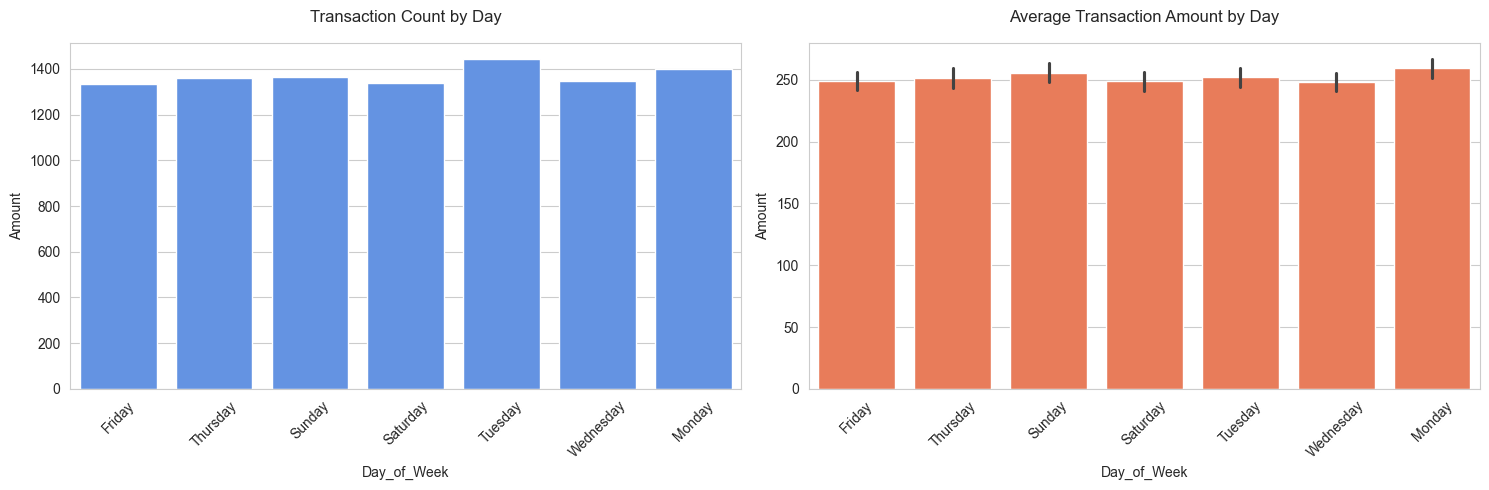

In [148]:
# Extract time-based features
time_features = master_df.copy()
time_features['Month'] = time_features['TxnDate'].dt.month_name()
time_features['Quarter'] = time_features['TxnDate'].dt.quarter
time_features['Day_of_Week'] = time_features['TxnDate'].dt.day_name()

# Analyze transactions by day of week
daily_sales = time_features.groupby('Day_of_Week')['Amount'].agg([
    'count',
    'mean',
    'sum'
]).round(2)

# Analyze transactions by month
monthly_sales = time_features.groupby('Month')['Amount'].agg([
    'count',
    'mean', 
    'sum'
]).round(2)

# Plot daily patterns
plt.figure(figsize=(15, 5))

# Create subplot for transaction counts by day
plt.subplot(1, 2, 1)
sns.barplot(
    data=time_features,
    x='Day_of_Week',
    y='Amount',
    estimator=len,
    color='#4F8EF7'
)
plt.title('Transaction Count by Day', fontsize=12, pad=15)
plt.xticks(rotation=45)

# Create subplot for average transaction amount by day
plt.subplot(1, 2, 2)
sns.barplot(
    data=time_features,
    x='Day_of_Week',
    y='Amount',
    estimator='mean',
    color='#FF7043'
)
plt.title('Average Transaction Amount by Day', fontsize=12, pad=15)
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()


**Customer Segmentation**: Create customer segments based on their spending habits.

In [149]:
# Step 1: Calculate comprehensive customer metrics
customer_analysis = master_df.groupby('custID').agg({
    'Amount': ['sum', 'mean', 'count'],
    'TxnDate': ['max', 'min'],
    'STORE_id': 'nunique'
}).round(2)

# Step 2: Flatten column names for easier access
customer_analysis.columns = ['total_spent', 'avg_transaction', 'transaction_count', 
                           'last_purchase', 'first_purchase', 'stores_visited']

# Step 3: Reset index to make custID a regular column
customer_analysis = customer_analysis.reset_index()

# Step 4: Calculate thresholds (70th percentile for both dimensions)
spending_threshold = customer_analysis['total_spent'].quantile(0.7)
frequency_threshold = customer_analysis['transaction_count'].quantile(0.7)

print(f"High Spending Threshold: ${spending_threshold:,.2f}")
print(f"High Frequency Threshold: {frequency_threshold:.0f} transactions")

# Step 5: Create the smart segmentation function
def smart_segment(row):
    high_spend = row['total_spent'] >= spending_threshold
    frequent = row['transaction_count'] >= frequency_threshold
    
    if high_spend and frequent:
        return 'Champions'           # High value + High frequency
    elif high_spend and not frequent:
        return 'Big Spenders'       # High value + Low frequency  
    elif not high_spend and frequent:
        return 'Loyal Low-Value'    # Low value + High frequency
    else:
        return 'At Risk'            # Low value + Low frequency

# Step 6: Apply segmentation
customer_analysis['Segment'] = customer_analysis.apply(smart_segment, axis=1)

# Step 7: Analyze the segments
segment_summary = customer_analysis.groupby('Segment').agg({
    'custID': 'count',                          # Number of customers
    'total_spent': ['mean', 'sum'],             # Average and total spending
    'transaction_count': 'mean',                # Average frequency
    'avg_transaction': 'mean',                  # Average transaction size
    'stores_visited': 'mean'                    # Average store diversity
}).round(2)

print("\n" + "="*60)
print("CUSTOMER SEGMENT ANALYSIS")
print("="*60)
print(segment_summary)

# Step 8: Calculate segment distribution
segment_distribution = customer_analysis['Segment'].value_counts()
segment_percentages = (customer_analysis['Segment']
                      .value_counts(normalize=True)
                      .mul(100)
                      .round(1))

print("\n" + "="*40)
print("SEGMENT DISTRIBUTION")
print("="*40)
for segment in segment_distribution.index:
    count = segment_distribution[segment]
    percentage = segment_percentages[segment]
    print(f"{segment}: {count} customers ({percentage}%)")

# # Step 10: Clean business insights using existing groupby results
# print("\n" + "="*50)
# print("BUSINESS INSIGHTS & ACTIONS")
# print("="*50)

# insights = {
#     'Champions': "🏆 Your best customers! Focus on retention and VIP treatment.",
#     'Big Spenders': "💰 High-value but infrequent. Target with personalized offers to increase frequency.",
#     'Loyal Low-Value': "🔄 Frequent shoppers with low spend. Try upselling and cross-selling.",
#     'At Risk': "⚠️ Low engagement. Consider win-back campaigns or investigate why they're not engaged."
# }

# # Use the already calculated segment_summary instead of recalculating
# for segment in segment_summary.index:
#     avg_spent = segment_summary.loc[segment, ('total_spent', 'mean')]
#     avg_frequency = segment_summary.loc[segment, ('transaction_count', 'mean')]
    
#     print(f"\n{segment}:")
#     print(f"  • {insights.get(segment, 'No insight available')}")
#     print(f"  • Average spending: ${avg_spent:,.2f}")
#     print(f"  • Average transactions: {avg_frequency:.1f}")

# # Step 11: Save the segmented customer data
# # customer_analysis.to_csv('customer_segments.csv', index=False)
# print(f"\n✅ Segmentation complete! {len(customer_analysis)} customers analyzed.")

High Spending Threshold: $2,778.33
High Frequency Threshold: 11 transactions

CUSTOMER SEGMENT ANALYSIS
                custID total_spent             transaction_count  \
                 count        mean         sum              mean   
Segment                                                            
At Risk            627     1811.50  1135810.48              7.41   
Big Spenders        44     2995.42   131798.42              9.59   
Champions          265     3490.64   925020.29             12.98   
Loyal Low-Value     94     2408.38   226387.33             11.53   

                avg_transaction stores_visited  
                           mean           mean  
Segment                                         
At Risk                  246.09           6.48  
Big Spenders             314.03           8.00  
Champions                270.43           9.70  
Loyal Low-Value          209.56           8.94  

SEGMENT DISTRIBUTION
At Risk: 627 customers (60.9%)
Champions: 265 customer

C:\Users\zzppo\AppData\Local\Temp\ipykernel_7408\3615588501.py:45: UserWarning: Glyph 127980 (\N{DEPARTMENT STORE}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\zzppo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 127980 (\N{DEPARTMENT STORE}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


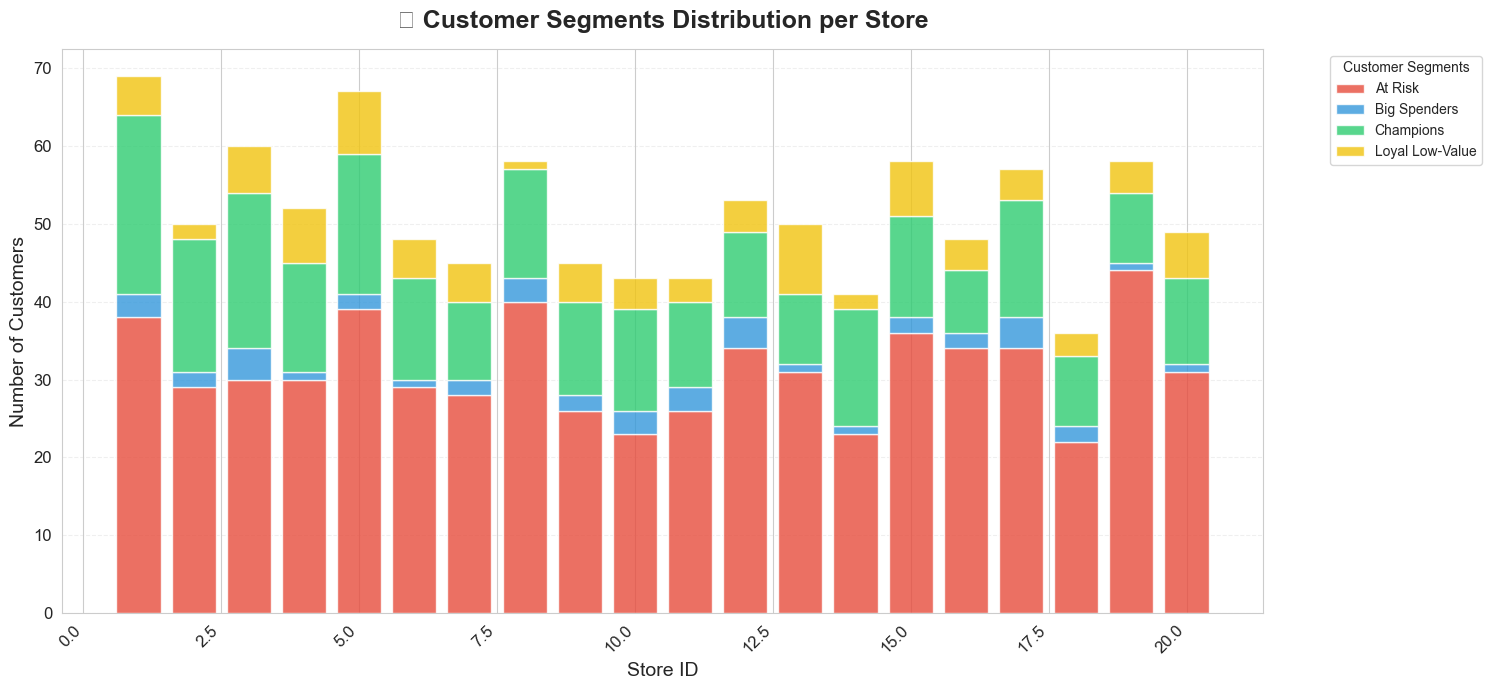


Store Statistics by Segment:
Segment  At Risk  Big Spenders  Champions  Loyal Low-Value
count      20.00         20.00      20.00            20.00
mean       31.35          2.20      13.25             4.70
std         6.03          1.06       3.93             2.05
min        22.00          1.00       8.00             1.00
25%        27.50          1.00      10.75             3.75
50%        30.50          2.00      13.00             4.50
75%        34.50          3.00      15.00             6.00
max        44.00          4.00      23.00             9.00


In [150]:
# Merge customer_analysis with store data to get segments
store_segment_df = pd.merge(
    customers_by_store_df,
    customer_analysis[['custID', 'Segment']],
    on='custID'
)

# Count customers by store and segment
store_segment_counts = store_segment_df.groupby(['PreferredStore', 'Segment'])['custID'].nunique().unstack().fillna(0)
store_totals = store_segment_counts.sum(axis=1)
store_segment_counts = store_segment_counts.loc[store_totals.sort_values().index]

# Define colors for segments
segment_colors = {
    'Champions': '#2ecc71',
    'Big Spenders': '#3498db',
    'Loyal Low-Value': '#f1c40f',
    'At Risk': '#e74c3c'
}

plt.figure(figsize=(15, 7))
bottom = np.zeros(len(store_segment_counts))

# Create stacked bars for each segment
for segment in store_segment_counts.columns:
    plt.bar(store_segment_counts.index, 
            store_segment_counts[segment], 
            bottom=bottom,
            label=segment,
            color=segment_colors[segment],
            alpha=0.8)
    bottom += store_segment_counts[segment]

plt.title('🏬 Customer Segments Distribution per Store', fontsize=18, weight='bold', pad=15)
plt.xlabel('Store ID', fontsize=14)
plt.ylabel('Number of Customers', fontsize=14)
plt.xticks(rotation=45, ha='right', fontsize=12)
plt.yticks(fontsize=12)

# Add legend with better placement
plt.legend(title='Customer Segments', bbox_to_anchor=(1.05, 1), 
          loc='upper left', fontsize=10)

plt.grid(axis='y', linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()

# Print summary of segments per store
print("\nStore Statistics by Segment:")
print(store_segment_counts.describe().round(2))

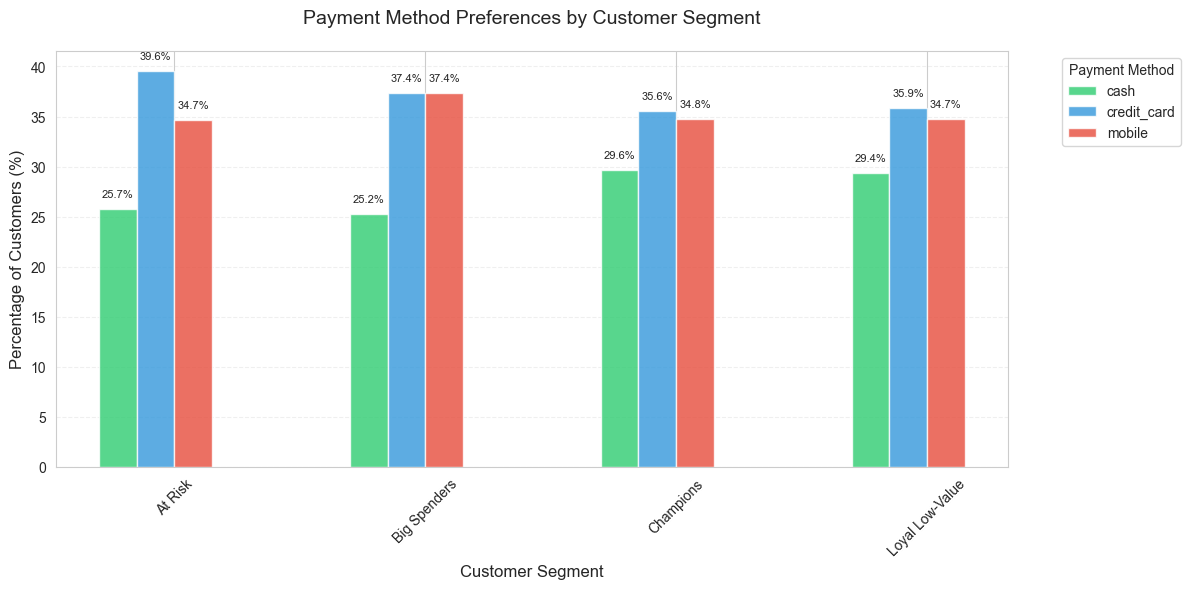


Payment Method Distribution by Segment:
PaymentMethod     cash  credit_card  mobile
Segment                                    
At Risk          25.75        39.59   34.66
Big Spenders     25.22        37.39   37.39
Champions        29.63        35.59   34.78
Loyal Low-Value  29.39        35.88   34.73


In [151]:
# Create a payment preference analysis by segment
payment_by_segment = pd.merge(
    master_df[['custID', 'PaymentMethod']],
    customer_analysis[['custID', 'Segment']],
    on='custID'
).drop_duplicates()

# Calculate the counts and percentages
segment_payment_counts = payment_by_segment.groupby(['Segment', 'PaymentMethod']).size().unstack(fill_value=0)
segment_payment_pct = segment_payment_counts.div(segment_payment_counts.sum(axis=1), axis=0) * 100

# Create a grouped bar plot
plt.figure(figsize=(12, 6))
bar_width = 0.15
x = np.arange(len(segment_payment_pct.index))

# Colors for different payment methods
colors = ['#2ecc71', '#3498db', '#e74c3c', '#f1c40f']

# Plot bars for each payment method
for i, (payment_method, color) in enumerate(zip(segment_payment_pct.columns, colors)):
    plt.bar(x + i * bar_width, 
            segment_payment_pct[payment_method], 
            bar_width,
            label=payment_method,
            color=color,
            alpha=0.8)

# Customize plot
plt.title('Payment Method Preferences by Customer Segment', fontsize=14, pad=20)
plt.xlabel('Customer Segment', fontsize=12)
plt.ylabel('Percentage of Customers (%)', fontsize=12)
plt.xticks(x + bar_width * 1.5, segment_payment_pct.index, rotation=45)
plt.legend(title='Payment Method', bbox_to_anchor=(1.05, 1))

# Add percentage labels on bars
for i, payment in enumerate(segment_payment_pct.columns):
    for j, value in enumerate(segment_payment_pct[payment]):
        plt.text(j + i * bar_width, value + 1, 
                f'{value:.1f}%', 
                ha='center', va='bottom',
                fontsize=8)

plt.grid(axis='y', linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()

# Print summary statistics
print("\nPayment Method Distribution by Segment:")
print(segment_payment_pct.round(2))